## Project theme: Recommendation systems

###### Our Goal
- In this notebook, we built a [collaborative filtering] based model (https://en.wikipedia.org/wiki/Collaborative_filtering) `Recommender System` by applying different approaches to provide meaningful `Resturant recommendations` from `TripAdvisor Website`.

###### About Data
- For our project, we choose dataset from `TripAdvisor` having restaurant data across 5 major states in USA from [`kaggle`](https://www.kaggle.com/datasets/siddharthmandgi/tripadvisor-restaurant-recommendation-data-usa).
- This dataset was scraped from the TripAdvisor website and it conatins restaurant data across 20 cities in Washington, Texas, California, New York, Pennsylvania, Oregon and New Jersey.

*Note:* Our dataset files can be also accessible here on [github](https://github.com/sifat-e-noor/Recommendation-system).

###### Our work    
To build our [collaborative filtering] based model (https://en.wikipedia.org/wiki/Collaborative_filtering) recommendation system we applied the followings approaches:
- Recommend top ten similar resturants based on customers reviews using using Jaccard similarity. Also verified similiarty results by impleneting TF-IDF to identify its relvencancy to rank the relevance of a comment for a query. Therefore, Find the most important words in similar resturants using TF-IDF to robust its keyword based search query in Search Engines.
- k-means
- Sentiment analysis

*Note:* Our codebase file can be accessible here on [github](https://github.com/sifat-e-noor/Recommendation-system).

## Recommending and Analyzing Similar Resturants Using Jaccard Similarity and TF-IDF

##### All important import(s) goes here

In [1]:
import os
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
import numpy as np
import mmh3
import pandas as pd
import requests
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

###### Download dataset (.csv) file from github

In [2]:
# Functin to download file from github
def file_exist(file_name):
    return file_name in os.listdir(os.getcwd())
def download_file(url,file_name):
    if file_exist(file_name):
        return
    response = requests.get(url)
    open(file_name, "wb").write(response.content)

In [3]:
# Load the dataset from git
url = "https://raw.githubusercontent.com/sifat-e-noor/Recommendation-system/main/Data/TripAdvisor_RestauarantRecommendation_cleandataset.csv"
download_file(url,"TripAdvisor_RestauarantRecommendation_cleandataset.csv")
df_dataset = pd.read_csv("TripAdvisor_RestauarantRecommendation_cleandataset.csv")

# Drop the index column from the downloaded dataset
df_dataset = df_dataset.drop(['Unnamed: 0'], axis=1)

# View the dataset's first 3 data
print(f"Our dataset's first 3 data:")
df_dataset.head(3)

# View full dataset
# df_dataset

Our dataset's first 3 data:


,Name,Street_Address,State,City,Zip_Code,Type,Reviews,No_of_Reviews,Comments,Price_Range
0,Coach House Diner,55 State Rt 4,NJ,Hackensack,07601-6337,"Diner, American, Vegetarian Friendly",4.0,84,"Both times we were there very late, after 11 P...",Medium
1,Table Talk Diner,2521 South Rd Ste C,NY,Poughkeepsie,12601-5476,"American, Diner, Vegetarian Friendly",4.0,256,Waitress was very friendly but a little pricey...,Medium
2,Sixty Vines,3701 Dallas Pkwy,TX,Plano,75093-7777,"American, Wine Bar, Vegetarian Friendly",4.5,235,Not sure why I went there for the second time....,Medium


In [4]:
# Obtain basic info of dataset 
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2439 entries, 0 to 2438
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            2439 non-null   object 
 1   Street_Address  2439 non-null   object 
 2   State           2439 non-null   object 
 3   City            2439 non-null   object 
 4   Zip_Code        2439 non-null   object 
 5   Type            2439 non-null   object 
 6   Reviews         2439 non-null   float64
 7   No_of_Reviews   2439 non-null   int64  
 8   Comments        2439 non-null   object 
 9   Price_Range     2439 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 190.7+ KB


In [5]:
# Find a specific state with the resturants Name, Type and Comments
df_NJstate_resturant_comment = df_dataset[df_dataset['State'] == 'NJ'][['Name','State','Type', 'Comments']]

In [6]:
# Find the resturants' unique Names 
df_NJ_unique_resturant = pd.DataFrame(df_NJstate_resturant_comment.Name.unique(), columns =["Name"])
df_NJ_unique_resturant.head(6)

,Name
0,Coach House Diner
1,Red Eye Cafe
2,Winberies Princeton
3,Breadsticks Cafe & Grill
4,BV Tuscany Italian Restaurant
5,Social 37


In [7]:
# Merge all comments as per resturants' Name
def prepare_doc_for_resturant_comments(resturant_name):
    return " ".join(df_NJstate_resturant_comment[df_NJstate_resturant_comment["Name"]==resturant_name]["Comments"].tolist())

df_NJ_unique_resturant["allcomments"] = df_NJ_unique_resturant['Name'].apply(prepare_doc_for_resturant_comments) 
df_NJ_unique_resturant

,Name,allcomments
0,Coach House Diner,"Both times we were there very late, after 11 P..."
1,Red Eye Cafe,My first time in this part of Montclair. Since...
2,Winberies Princeton,We brought our family here for dinner on a Sat...
3,Breadsticks Cafe & Grill,We dined for lunch (group of four) and all ord...
4,BV Tuscany Italian Restaurant,BV Tuscany is in a great location with shops a...
...,...,...
499,Chick's Deli,A hole in the wall with great food. Aren't the...
500,Uncle Bill's Pancake House,Called restaurant at the last minute to see if...
501,BRIO Tuscan Grille,We come to Brio once a month. They are good fo...
502,Maywood Pancake house,Stopped in yesterday for Breakfast. When in Je...


In [8]:
# Remove stowords from all_comments
def remove_stopwords(doc):
    doc_text = nltk.word_tokenize(doc)
    stopwords = nltk.corpus.stopwords.words('english')
    doc_text = " ".join([token.lower() for token in doc_text if token.isalpha() and token.lower() not in stopwords])
    return doc_text

df_NJ_unique_resturant["allcomments"] = df_NJ_unique_resturant["allcomments"].apply(remove_stopwords)

In [9]:
# Convert dataframe to dict
data_dict = {}

for name, comment in zip(df_NJ_unique_resturant["Name"], df_NJ_unique_resturant["allcomments"]):
    data_dict[name] = comment    

In [10]:
# Hashes a list of strings
def listhash(l,seed):
    val = 0
    for e in l:
        val = val ^ mmh3.hash(e, seed)
    return val 

In [11]:
# Get minhash of given shingles
def minhash1(shingles_list, seed):
    minhash_value = None
    for aShingle in shingles_list:
        hashcode = listhash([aShingle], seed)
        if minhash_value == None or hashcode < minhash_value:
            minhash_value = hashcode
    return minhash_value

In [12]:
# Get sequence of k minhashes
def minhash2(shingles_list, k):
    all_minhash = []
    for i in range(k):
        all_minhash.append(minhash1(shingles_list, i))
    return all_minhash

In [13]:
# Get list of unique shingles
def shingle(aString, q, delimiter=' '):
    all_shingles = []
    if delimiter != '':
        words_list = aString.split(delimiter)
    else:
        words_list = aString
    for i in range (len(words_list)-q+1):
        all_shingles.append(delimiter.join(words_list[i:i+q]))
    return list(set(all_shingles))

In [14]:
# Get dictionary consisting of document id’s as keys and signatures as values
q = 1 # length of shingle
k = 100 # number of minhashes
def signature(dict_docs, q = q, num_hashes = k):
    dict_signatures = {}
    total_texts = len(list(dict_docs.keys()))
    counter = 1
    for key,text in dict_docs.items():
        print(f'{counter}/{total_texts} - {key} - Processing...')
        doc_shingles = shingle(text, q)
        minhash_values = minhash2(doc_shingles, num_hashes)
        dict_signatures[key] = minhash_values
        counter += 1
    return dict_signatures

In [15]:
dict_signatures_docs = signature(data_dict)

1/504 - Coach House Diner - Processing...
2/504 - Red Eye Cafe - Processing...
3/504 - Winberies Princeton - Processing...
4/504 - Breadsticks Cafe & Grill - Processing...
5/504 - BV Tuscany Italian Restaurant - Processing...
6/504 - Social 37 - Processing...
7/504 - Buddakan - Processing...
8/504 - Moore's Tavern & Restaurant - Processing...
9/504 - Fin Raw Bar and Kitchen - Processing...
10/504 - Bisque Restaurant - Processing...
11/504 - The Cheesecake Factory - Processing...
12/504 - Seasons 52 - Processing...
13/504 - Esquina Latina - Processing...
14/504 - LuNello's Resturant - Processing...
15/504 - Ironbound - Processing...
16/504 - Sbarro - Processing...
17/504 - Brasilia Grill - Processing...
18/504 - Metropolitan Cafe - Processing...
19/504 - INC Restaurant - Processing...
20/504 - Jon & Patty's Coffee Bar & Bistro - Processing...
21/504 - Forno's of Spain Restaurant - Processing...
22/504 - Pj's Pancake House - Processing...
23/504 - Rainbow Diner Restaurant - Processing...

252/504 - Edison Diner - Processing...
253/504 - D'Angelo - Processing...
254/504 - Aqua Blu Kitchen & Cocktails - Processing...
255/504 - Hobby's Delicatessen & Restaurant - Processing...
256/504 - Taverna Mykonos - Processing...
257/504 - Metro Grill - Processing...
258/504 - Panico's - Processing...
259/504 - Chateau of Spain Restaurant - Processing...
260/504 - Edison Family Restaurant - Processing...
261/504 - Blooming Grove Inn - Processing...
262/504 - Stone Fire Grille - Processing...
263/504 - Efes Mediterranean Grill - Processing...
264/504 - Mishmish Cafe - Processing...
265/504 - Pisces Restaurant - Processing...
266/504 - Marsilios Kitchen - Processing...
267/504 - Pho Anh Dao - Processing...
268/504 - Varsity Inn - Processing...
269/504 - Aldo's Cucina - Processing...
270/504 - Kenko Sushi - Processing...
271/504 - Enzo's La Piccola Cucina - Processing...
272/504 - Fortune Buffet - Processing...
273/504 - Benny Tudino's - Processing...
274/504 - Il Villaggio Restaurant - 

In [16]:
# Find similar resturants of a given resturant
def jaccard(name1,name2,dict_signatures_docs):
    signatures_doc1 = np.array(dict_signatures_docs[name1])
    signatures_doc2 = np.array(dict_signatures_docs[name2])
    return len(np.intersect1d(signatures_doc1, signatures_doc2))/len(np.union1d(signatures_doc1, signatures_doc2))  

_input="Coach House Diner"
def apply_jaccard_(name):
     return jaccard(_input,name,dict_signatures_docs)
df_NJ_unique_resturant["Jaccard_Similarity"]=df_NJ_unique_resturant["Name"].apply(apply_jaccard_)

print(f'Jaccard similarity between {_input} and other {len(df_NJ_unique_resturant.Name)} resturants of New Jersy State:')
df_NJ_unique_resturant[:11]

Jaccard similarity between Coach House Diner and other 504 resturants of New Jersy State:


,Name,allcomments,Jaccard_Similarity
0,Coach House Diner,times late pm time many diners forget restaura...,1.000000
1,Red Eye Cafe,first time part montclair since arrived pm nev...,0.086957
2,Winberies Princeton,brought family dinner saturday busy staff atte...,0.052632
3,Breadsticks Cafe & Grill,dined lunch group four ordered offering excell...,0.030928
4,BV Tuscany Italian Restaurant,bv tuscany great location shops local movie th...,0.047120
5,Social 37,went recently saturday night birthday celebrat...,0.000000
6,Buddakan,ca tell enough amazing food edamam ravioli die...,0.015228
7,Moore's Tavern & Restaurant,tuesdays moore burgers burgers good large serv...,0.063830
8,Fin Raw Bar and Kitchen,oh food freshest ever sushi bar rocks wait sta...,0.047120
9,Bisque Restaurant,three star restaurant open year elegant dining...,0.000000


The above model is able to predict the similar restauratns for a specific restaurent query from any state
  - Input:
        - resturant name as query 
  - Return:
        - dataframe of similar type of restaurents name based on users' comments
 

In [17]:
# Convert Jaccard_Similarity column's data to float
df_NJ_unique_resturant['Jaccard_Similarity'] = df_NJ_unique_resturant['Jaccard_Similarity'].apply(float)

In [18]:
# Find top 10 similar resturants of a given resturant
df_ten_similar_resturant = df_NJ_unique_resturant.nlargest(11, 'Jaccard_Similarity')
df_ten_similar_resturant

,Name,allcomments,Jaccard_Similarity
0,Coach House Diner,times late pm time many diners forget restaura...,1.000000
188,The River Palm Terrace,excellent service delicious food complaint go ...,0.117318
196,Tre Pizza Pasta Beer Garden,jersey shore need great place eat food terrifc...,0.117318
275,Sang Kee Noodle Cafe,wonderful place great meal always busy tables ...,0.117318
300,Vidalia Restaurant,mothers birthday celebration people wonderful ...,0.117318
22,Rainbow Diner Restaurant,recently rainbow diner dinner many times food ...,0.104972
102,Noah's Ark,good food good menu good service else say ahh ...,0.104972
96,El Familiar,always enjoyed food service get takeout way ea...,0.098901
213,Pinky Shrimp's Seafood Co,place go friendly people food great price amaz...,0.098901
349,Samba,glad back food still amazing service fabulous ...,0.098901


We looked for important words among the similar resturants to analyze that whether the search keywords will help to appear these recommendations in search engines for this query (Search by secfic restaurant name) and whether the above similarity among resturants are in positive cluster or negative.

In [19]:
# Find important words from resturants all_comments
tfidf_vectorizer = TfidfVectorizer(ngram_range=[1, 1])

tfidf_separate = tfidf_vectorizer.fit_transform(df_ten_similar_resturant['allcomments'])

word_list = tfidf_vectorizer.get_feature_names_out()

count_list = tfidf_separate.toarray().sum(axis=0)

vocab_df = pd.DataFrame((zip(word_list,count_list)),
                          columns= ["vocab","tfidf_value"])
# vocab_df
vocab_df.sort_values(by="tfidf_value",ascending=False)[:31]

,vocab,tfidf_value
53,good,1.525912
45,food,1.303602
107,service,1.109468
4,always,1.004160
82,people,0.801767
49,get,0.650330
65,many,0.637503
54,great,0.628816
85,place,0.628816
51,go,0.607913


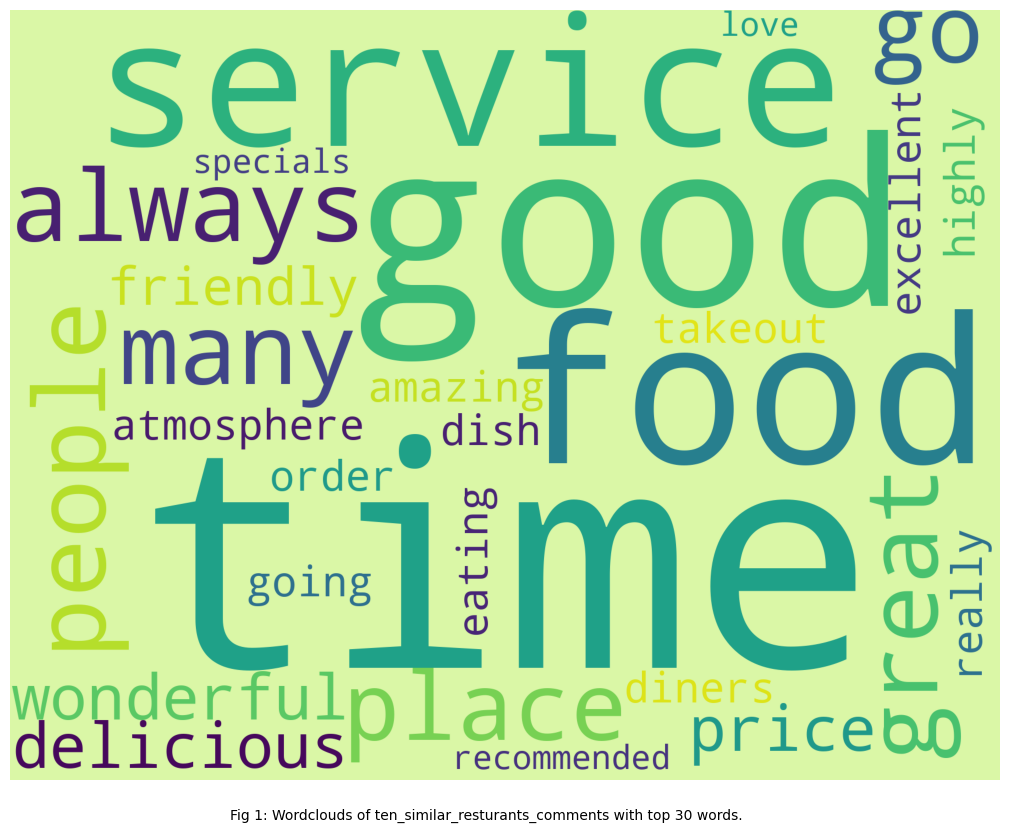

In [20]:
# Visulize important keywords of top ten similar resturants
ten_similar_resturant_comments = " ".join(vocab_df.sort_values(by="tfidf_value",ascending=False)["vocab"][:31].tolist())

wordcloud = WordCloud(background_color='#DAF7A6',
                      width=1800,
                      height=1400).generate(ten_similar_resturant_comments)
img=plt.imshow(wordcloud)
plt.figtext(0.5, 0.07,'Fig 1: Wordclouds of ten_similar_resturants_comments with top 30 words.', wrap=True, horizontalalignment='center', fontsize=10) 
plt.axis("off")
# Save the file
# plt.savefig("resturants_wordcloud.png")
# Show the wordcloud
plt.show()